# Wealth Mapping with Alpha Earth Embeddings

This notebook contains code for pulling and visualizing experimenting with Alpha Earth embeddings. We then use these embeddings to predict wealth and poverty across various countries in the SustainBench dataset, matched spatially and temporally.

## Setup
1. Clone the repo 
2. Setup your conda environment with environment.yml (change the prefix for your environment name):
   ```bash
   conda env create -f environment.yml
   conda activate gee
   ```
3. Create your own Earth Engine account and follow the instructions [here](https://developers.google.com/earth-engine/guides/python_install) to authenticate your account.
4. Run all the cells. You should get a visualization that looks like this of AlphaEarth embeddings over Boston:

   ![Boston Embeddings](boston-embeddings.png)

5. Pull data from SustainBench for poverty prediction and run the rest of the cells in the notebook to extract AlphaEarth embeddings for the survey clusters and train a regression model to predict wealth. Visualize the errors geographically for a map like this:

   ![Wealth Prediction Errors](prediction-errors.png)


In [1]:
import ee

ee.Authenticate()

ee.Initialize()

In [2]:
embeddings = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')

In [3]:
pt = ee.Geometry.Point(-71.0565, 42.3555)
image = embeddings.filterDate('2023-01-01', '2024-01-01').filterBounds(pt)

In [4]:
# visualize three axes of embedding space as RGB
vis = {'min': -0.3, 'max': 0.3, 'bands': ['A01', 'A16', 'A09']}

In [5]:
import geemap.core as geemap


In [6]:

m = geemap.Map(center=(42.3555, -71.0565), zoom=9)
m.addLayer(image, vis, '2023 Embedding')

In [7]:
m

Map(center=[42.3555, -71.0565], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

## Sustain Bench - Poverty Over Time
Get the data from Sustain Bench for mapping poverty over time and any other temporal tasks.

[Sustain Bench Task 1A](https://sustainlab-group.github.io/sustainbench/docs/datasets/sdg1/change_in_poverty.html)

[Data in Google Drive](https://drive.google.com/drive/folders/15YaE7Wl3PLkTooAQipRnNfMbcXabAbMp)

In [8]:
import pandas as pd
import geopandas as gpd

In [9]:
# read in sustainbench data
datapath = 'data/poverty_change/'
filename = 'lsms_asset_diff_indices.csv'
df_pov_change = pd.read_csv(datapath+filename)
df_pov_change.head()

,country,cluster_id,year.x,year.y,lat,lon,lsms_id.x,lsms_id.y,diff_of_index,index_of_diff,asset_index.x,asset_index.y,n
0,et,1010201403,2011,2015,14.288590,38.210252,et_01010201403_2011,et_01010201403_2015,0.293512,0.289872,-2.324146,-2.030634,5
1,et,1010300106,2011,2015,14.109761,38.473835,et_01010300106_2011,et_01010300106_2015,0.402204,0.324878,0.946298,1.348502,6
2,et,1010301804,2011,2015,13.844084,38.480325,et_01010301804_2011,et_01010301804_2015,0.269226,0.211552,-2.194513,-1.925287,5
3,et,1010600402,2011,2015,13.642517,38.119182,et_01010600402_2011,et_01010600402_2015,1.290143,1.007329,-2.469920,-1.179777,4
4,et,1020100207,2011,2015,14.283468,38.573016,et_01020100207_2011,et_01020100207_2015,-0.948477,-0.798657,-1.117476,-2.065952,4


In [10]:
# summarize number of datapoints by year
df_pov_change.value_counts('year.x')

year.x
2010    563
2005    378
2008    300
2011    235
2009    189
Name: count, dtype: int64

In [11]:
df_pov_change.value_counts('year.y')

year.y
2015    697
2013    378
2012    300
2009    189
2016    101
Name: count, dtype: int64

All repeated surveys happen between 2005 and 2016, so there is no overlap with the AlphaEarth Foundations embeddings from 2017-2024. The dataset was created in 2021, so it's possible there have been repeated surveys since then. One would need to process the new DHS data to find out.

## Sustain Bench Poverty Over Space
Task: https://sustainlab-group.github.io/sustainbench/docs/datasets/dhs.html

Data: https://drive.google.com/drive/folders/1tzWDfd4Y5MvJnJb-lHieOuD-aVcUqzcu

Downlaod the data from SustainBench and put in in your working directory. For example:

alphaearth/

-- data/

---- poverty/

------ dhs_final_labels.csv

---- poverty_change/

------ lsms_asset_diff_indices.csv

In [ ]:
datapath = 'data/poverty/'
filename = 'dhs_final_labels.csv'
df_pov = pd.read_csv(datapath+filename)
df_pov.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,under5_mort,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.0,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,0.0,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R


In [13]:
df_pov.value_counts('year').sort_index()

year
1996      343
1997      585
1998      992
1999      894
2000     5107
2001      893
2002      495
2003     4850
2004     3129
2005     4246
2006     3152
2007     5479
2008     6583
2009     2425
2010     9259
2011     4814
2012     5379
2013     4532
2014     6559
2015    31839
2016     4482
2017     6406
2018     3826
2019     1375
Name: count, dtype: int64

Last surveys are from 2019, so there is some overlap with the AlphaEarth Foundations embeddings, but not much. Only about 10% of the data is from 2017-2019.

In [14]:
# convert from pandas to geopandas
gdf_pov = gpd.GeoDataFrame(
    df_pov, geometry=gpd.points_from_xy(df_pov.lon, df_pov.lat))
gdf_pov.crs = "EPSG:4326"
gdf_pov.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban,geometry
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R,POINT (19.83832 40.82265)
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R,POINT (20.00756 40.69685)
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R,POINT (19.97426 40.75004)
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R,POINT (19.86334 40.79893)
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R,POINT (19.84388 40.74612)


In [15]:
# visualize dhs data points on map with lonboard and geopandas
from lonboard import viz
viz(gdf_pov)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [16]:
# filter to just data from 2017 onwards
gdf_pov_recent = gdf_pov[gdf_pov['year'] >= 2017]
gdf_pov_recent.head()

# drop some columns not needed
# drop lon, lat
# filter out rows that have NaN for asset_index
gdf_pov_recent = gdf_pov_recent.drop(columns=['lon', 'lat', 'adm1fips', 'adm1dhs','DHSID_EA'])
gdf_pov_recent = gdf_pov_recent.dropna(subset=['asset_index'])
gdf_pov_recent.head()

,cname,year,n_asset,asset_index,n_water,water_index,n_sanitation,sanitation_index,under5_mort,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,urban,geometry
5010,BD,2017,29.0,-1.376459,29.0,3.0,29.0,2.620690,0.0,11.0,5.677419,21.676800,31.0,25.0,1,R,POINT (90.10647 21.90745)
5011,BD,2017,30.0,-1.451064,30.0,3.0,30.0,2.833333,0.0,17.0,4.888889,22.983889,27.0,18.0,2,R,POINT (90.29871 22.17195)
5012,BD,2017,29.0,-1.008796,29.0,3.0,29.0,2.965517,0.0,15.0,5.478261,22.374783,23.0,23.0,3,R,POINT (90.18748 22.16715)
5013,BD,2017,30.0,-1.266641,30.0,3.0,30.0,2.800000,0.0,12.0,6.794118,23.681875,34.0,32.0,4,R,POINT (90.12206 22.19562)
5014,BD,2017,29.0,-1.265830,29.0,3.0,29.0,2.655172,0.0,14.0,5.931034,23.154615,29.0,26.0,5,R,POINT (90.17927 22.3489)


In [17]:
# export as geojson
geojson_filename = 'dhs_recent.geojson'
gdf_pov_recent.to_file(datapath+geojson_filename, driver='GeoJSON')

## Match DHS Points to GEE Embeddings
1. Convert DHS data to Earth Engine collection
2. Convert to circles with 2km radius for urban, 5km for rural 
3. Use reduceRegions to get mean embedding for each DHS point
4. Export to CSV

In [18]:
import geemap
# convert gdf to ee.FeatureCollection
# fc_pov2 = geemap.gdf_to_ee(gdf_pov_recent)
fc_pov = geemap.geojson_to_ee(datapath+geojson_filename)

In [19]:
m = geemap.Map(center=(0, 20), zoom=3)
m.addLayer(fc_pov, {'color': 'blue'}, "DHS Points")
m

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', trans…

In [20]:
fc_pov.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [90.106474, 21.907454]},
 'id': '0',
 'properties': {'asset_index': -1.3764592156813944,
  'cluster_id': 1,
  'cname': 'BD',
  'n_asset': 29,
  'n_sanitation': 29,
  'n_under5_mort': 11,
  'n_water': 29,
  'n_women_bmi': 25,
  'n_women_edu': 31,
  'sanitation_index': 2.6206896551724137,
  'under5_mort': 0,
  'urban': 'R',
  'water_index': 3,
  'women_bmi': 21.6768,
  'women_edu': 5.67741935483871,
  'year': 2017}}

In [21]:
# convert year into system:time_start property
def add_time_start(feature):
    year = ee.Number(feature.get('year'))
    # Example: January 1st of the year
    millis = ee.Date.fromYMD(year, 1, 1).millis()
    return feature.set('system:time_start', millis)

fc_pov_with_time = fc_pov.map(add_time_start)
fc_pov_with_time.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [90.106474, 21.907454]},
 'id': '0',
 'properties': {'asset_index': -1.3764592156813944,
  'cluster_id': 1,
  'cname': 'BD',
  'n_asset': 29,
  'n_sanitation': 29,
  'n_under5_mort': 11,
  'n_water': 29,
  'n_women_bmi': 25,
  'n_women_edu': 31,
  'sanitation_index': 2.6206896551724137,
  'system:time_start': 1483228800000,
  'under5_mort': 0,
  'urban': 'R',
  'water_index': 3,
  'women_bmi': 21.6768,
  'women_edu': 5.67741935483871,
  'year': 2017}}

In [22]:
# convert each feature that's 'urban': 'R' to a 5km circle, 'U' to 2km circle
def buffer_by_urban_rural(feature):
    urban_rural = ee.String(feature.get('urban'))
    radius = ee.Number(ee.Algorithms.If(urban_rural.equals('U'), 2000, 5000))  # in meters
    buffered_geom = feature.geometry().buffer(radius)
    return feature.setGeometry(buffered_geom)

fc_pov_buffered = fc_pov_with_time.map(buffer_by_urban_rural)
fc_pov_buffered.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[90.106474, 21.952448329757406],
    [90.0929242060707, 21.950657000633566],
    [90.08045393244645, 21.945425732261054],
    [90.07005647038329, 21.937171280757347],
    [90.06255961071251, 21.92655115693895],
    [90.05855970438274, 21.914411145745614],
    [90.05837431819705, 21.901717849677908],
    [90.06201721475684, 21.889481667043608],
    [90.06919756722291, 21.87867636083684],
    [90.07934337455768, 21.870161621422255],
    [90.0916471309303, 21.86461476372806],
    [90.10513007139963, 21.86247695575551],
    [90.11871989013373, 21.863918214229486],
    [90.13133580443927, 21.868823918796405],
    [90.14197428403541, 21.87680390350954],
    [90.14978871498823, 21.88722341192708],
    [90.15415672461073, 21.89925348346682],
    [90.15472982895463, 21.911936803845133],
    [90.15146141816709, 21.924263819925606],
    [90.14461077571728, 21.93525308761795],
    [90.13472271517368, 21.94402946125434],
    [9

In [23]:
# try to match a single feature to an image and get embedding values
ft = fc_pov_buffered.first()
year = ee.Number(ft.get('year'))
image = embeddings.filter(ee.Filter.calendarRange(year, year, 'year')).filterBounds(ft.geometry()).first()
image

In [24]:
# reduce the image over the feature geometry to get mean embedding values
embedding_values = image.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ft.geometry(),
    scale=2000
)
print(embedding_values.getInfo())

# variation by scale
# 2000m
# {'A00': 0.03583230975099487, 'A01': -0.05868585758724169, 'A02': 0.04828265352486806, 'A03': -0.03910224339290082, 'A04': -0.07338382590112695, 'A05': 0.10040952031436462, 'A06': 0.07469091558191907, 'A07': 0.02286804026423404, 'A08': -0.07577565072374762, 'A09': 0.3013911482596604, 'A10': 0.07351857677117193, 'A11': 0.008769017410885923, 'A12': -0.2795098538524144, 'A13': -0.04067630082335964, 'A14': 0.007487442392286684, 'A15': 0.13000420667375687, 'A16': -0.15363397943847773, 'A17': 0.029954550447630037, 'A18': -0.1459742881109663, 'A19': 0.03134522436425551, 'A20': -0.27873316706361695, 'A21': 0.2468679129405773, 'A22': -0.027948279133400245, 'A23': 0.060070914283717046, 'A24': 0.09891742436725136, 'A25': 0.15968814441997836, 'A26': 0.054844827414031565, 'A27': -0.04544374790914585, 'A28': -0.06753590027811483, 'A29': 0.10958732155963993, 'A30': 0.0851869535693065, 'A31': 0.08353888614269238, 'A32': -0.12098027981245973, 'A33': -0.032616014320166566, 'A34': 0.18979035286128712, 'A35': 0.16240413277610513, 'A36': -0.08705842408264557, 'A37': 0.01165832821542164, 'A38': 0.20790114441498528, 'A39': 0.0999573340922822, 'A40': 0.09392022049461496, 'A41': 0.051902702257373534, 'A42': -0.07304564428266852, 'A43': 0.24091693005187814, 'A44': -0.022394620949984276, 'A45': 0.12302783145343696, 'A46': 0.024674800401444003, 'A47': 0.1059101644222752, 'A48': -0.044020993424107605, 'A49': 0.13290897107506103, 'A50': 0.015047683957718562, 'A51': 0.08655386040334136, 'A52': -0.003795593103551581, 'A53': -0.044226383958217874, 'A54': 0.2885844979703111, 'A55': -0.12836339170249206, 'A56': 0.020580708219116527, 'A57': -0.03316391797360656, 'A58': -0.1001967275323677, 'A59': -0.031444636678200695, 'A60': 0.028908336953319652, 'A61': -0.089986581085197, 'A62': 0.015343162220324849, 'A63': 0.06701353625229059}
# 1000m
# {'A00': 0.03481271163490991, 'A01': -0.05594536681821433, 'A02': 0.04529522176786921, 'A03': -0.03688662679341079, 'A04': -0.06889645994742906, 'A05': 0.09973965045305627, 'A06': 0.06984619295545244, 'A07': 0.017960080867170068, 'A08': -0.07866600104232897, 'A09': 0.2985257121331164, 'A10': 0.07821992300493785, 'A11': 0.01371763274708313, 'A12': -0.2674301369259616, 'A13': -0.04385100762259716, 'A14': 0.009898687625467278, 'A15': 0.12622457591595196, 'A16': -0.14892357520894492, 'A17': 0.026366437637962818, 'A18': -0.1419214468725958, 'A19': 0.026061783565433146, 'A20': -0.27179187600943167, 'A21': 0.24356622577906728, 'A22': -0.02884406061119342, 'A23': 0.06431191842868295, 'A24': 0.08769955913574758, 'A25': 0.15106016007008471, 'A26': 0.046134445415487085, 'A27': -0.042536755598101675, 'A28': -0.05821022347385746, 'A29': 0.10484388480792214, 'A30': 0.08176645165786516, 'A31': 0.08963079581467584, 'A32': -0.1074485966585588, 'A33': -0.029586378445024732, 'A34': 0.18277309659737995, 'A35': 0.15923474291330025, 'A36': -0.0781525838927043, 'A37': 0.008330587817771077, 'A38': 0.20084012250896496, 'A39': 0.10949589618237042, 'A40': 0.0926602340490974, 'A41': 0.052373405447695115, 'A42': -0.06530570264682176, 'A43': 0.23214762042704062, 'A44': -0.020552241344816424, 'A45': 0.11306330954794457, 'A46': 0.018600745654126984, 'A47': 0.10697815986778252, 'A48': -0.041070623244192556, 'A49': 0.12812344424757047, 'A50': 0.013616496448203865, 'A51': 0.0861259058435735, 'A52': -0.007594595477470572, 'A53': -0.04466483590789988, 'A54': 0.2758680277762164, 'A55': -0.12936442389670752, 'A56': 0.020402371974468207, 'A57': -0.03553647946089175, 'A58': -0.09930380153561709, 'A59': -0.03218656096835462, 'A60': 0.014419488590307379, 'A61': -0.08894858262114624, 'A62': 0.016468176485238507, 'A63': 0.07034321736446027}
# 500m
# {'A00': 0.036578499860688944, 'A01': -0.05791379288875197, 'A02': 0.04448329356351574, 'A03': -0.0343000014008938, 'A04': -0.06875603590646395, 'A05': 0.09509153206412355, 'A06': 0.06585293728509904, 'A07': 0.020320445110647265, 'A08': -0.07914279932819365, 'A09': 0.2901480456753633, 'A10': 0.07452305715490945, 'A11': 0.010431574900341982, 'A12': -0.2628742876844314, 'A13': -0.042265764335423735, 'A14': 0.007318431714989723, 'A15': 0.12141540469486203, 'A16': -0.14045205518898826, 'A17': 0.022443769680611802, 'A18': -0.13745461726803895, 'A19': 0.029234255121434145, 'A20': -0.26109465839205404, 'A21': 0.23511839887181343, 'A22': -0.02429846664394106, 'A23': 0.0601555069912382, 'A24': 0.0854524583350844, 'A25': 0.14938748176892397, 'A26': 0.047655879784635875, 'A27': -0.04321364641752549, 'A28': -0.05637120649641138, 'A29': 0.10501868558807191, 'A30': 0.07863979596760505, 'A31': 0.08631648213782642, 'A32': -0.10189612761830945, 'A33': -0.030231625332517695, 'A34': 0.1758482403995971, 'A35': 0.15422565441195907, 'A36': -0.07595117418246171, 'A37': 0.006158485447048553, 'A38': 0.19520601465957518, 'A39': 0.10328082472172805, 'A40': 0.08742171961266847, 'A41': 0.05080746427331752, 'A42': -0.06252248823638372, 'A43': 0.22901237689645995, 'A44': -0.019962162637540554, 'A45': 0.10905791372673548, 'A46': 0.016408865634052323, 'A47': 0.10741201531021245, 'A48': -0.041191549653123063, 'A49': 0.12528431294721573, 'A50': 0.013151910585620295, 'A51': 0.08057226121376548, 'A52': -0.0068712080529600116, 'A53': -0.0423755173578521, 'A54': 0.2694740126422878, 'A55': -0.12730421886941645, 'A56': 0.01906441465210361, 'A57': -0.03246198519099633, 'A58': -0.09578762839580532, 'A59': -0.02889682573037154, 'A60': 0.0178299019218706, 'A61': -0.08703953244392144, 'A62': 0.01573998477695436, 'A63': 0.06945301324467242}
# 100m
# {'A00': 0.036108371550511546, 'A01': -0.05598663937289979, 'A02': 0.043299633043500464, 'A03': -0.03415575004011105, 'A04': -0.06679075946831117, 'A05': 0.09131783050829273, 'A06': 0.06257923929975473, 'A07': 0.020500911411077058, 'A08': -0.07652376152089868, 'A09': 0.2821571347423175, 'A10': 0.07156058929043027, 'A11': 0.012454139284957134, 'A12': -0.2543412604903599, 'A13': -0.04157583911902149, 'A14': 0.006021400708850217, 'A15': 0.11760638565229417, 'A16': -0.137730305253919, 'A17': 0.022482345667180378, 'A18': -0.13151265130878523, 'A19': 0.027563267050601477, 'A20': -0.2555571770963498, 'A21': 0.2285734780497037, 'A22': -0.02228345024448541, 'A23': 0.0578045007858795, 'A24': 0.08235074609566148, 'A25': 0.14517263984980924, 'A26': 0.04477276708312992, 'A27': -0.03996105224599208, 'A28': -0.05447370567497873, 'A29': 0.10107459658259121, 'A30': 0.07657410966232464, 'A31': 0.08434162491771943, 'A32': -0.09887445988996911, 'A33': -0.02880841631225394, 'A34': 0.17124900463217377, 'A35': 0.1484415366340958, 'A36': -0.07305430031887823, 'A37': 0.00526643711328007, 'A38': 0.1892287800182653, 'A39': 0.1004151176055086, 'A40': 0.08622084653387635, 'A41': 0.050142151079635676, 'A42': -0.059993750508902634, 'A43': 0.22220614785034754, 'A44': -0.018454189699598156, 'A45': 0.10475215409413682, 'A46': 0.015136518183455072, 'A47': 0.10324870399316437, 'A48': -0.03868878164381196, 'A49': 0.1221201897621234, 'A50': 0.012285961220702954, 'A51': 0.07752037450728759, 'A52': -0.005474941785323169, 'A53': -0.04089682071138646, 'A54': 0.2597857393968169, 'A55': -0.12361047372019358, 'A56': 0.018547775868132582, 'A57': -0.03239493288670129, 'A58': -0.09351792686266693, 'A59': -0.026190862722283822, 'A60': 0.016942375481453, 'A61': -0.08429377435506288, 'A62': 0.014623150598999105, 'A63': 0.0670397712742539}
# 50m
# {'A00': 0.036085537499694086, 'A01': -0.05548275140971035, 'A02': 0.04307754055001857, 'A03': -0.03378782864982446, 'A04': -0.06623116779211374, 'A05': 0.09026758445166103, 'A06': 0.06202361110438186, 'A07': 0.020543443925789388, 'A08': -0.07619312837165601, 'A09': 0.28010445044453613, 'A10': 0.0706675501159378, 'A11': 0.012450605493897681, 'A12': -0.25261915685658015, 'A13': -0.04130319173392991, 'A14': 0.00582009602507959, 'A15': 0.11642150569900925, 'A16': -0.13633036225716513, 'A17': 0.022299617433523534, 'A18': -0.1302603266135699, 'A19': 0.027756638351513457, 'A20': -0.2536279698605394, 'A21': 0.2268927985928222, 'A22': -0.021357176300377537, 'A23': 0.05709434307358947, 'A24': 0.08199905790337145, 'A25': 0.14436426943741218, 'A26': 0.04452054770743444, 'A27': -0.039583517797359684, 'A28': -0.05399284723452823, 'A29': 0.10051866812468549, 'A30': 0.07610725228963093, 'A31': 0.08377650825287228, 'A32': -0.09777230452399267, 'A33': -0.028709391330874013, 'A34': 0.1700587790217618, 'A35': 0.14700119097133799, 'A36': -0.0723678666325534, 'A37': 0.0054338270198577305, 'A38': 0.1877186430029593, 'A39': 0.09907638389015194, 'A40': 0.08544953756870699, 'A41': 0.04945820697989388, 'A42': -0.05964563057358378, 'A43': 0.22116912446720544, 'A44': -0.017822908234319958, 'A45': 0.10380164111226105, 'A46': 0.014838540039380775, 'A47': 0.10240402856570753, 'A48': -0.03808079869820352, 'A49': 0.12128797358375132, 'A50': 0.012060007495121322, 'A51': 0.0767023661323268, 'A52': -0.005346906692551554, 'A53': -0.040285800382936485, 'A54': 0.25779437547062617, 'A55': -0.1230613269578868, 'A56': 0.01834557117862811, 'A57': -0.032118270440714115, 'A58': -0.0928466134857465, 'A59': -0.026086050494558373, 'A60': 0.01673587065988864, 'A61': -0.08363121617720201, 'A62': 0.014011153684349803, 'A63': 0.06651764279839907}
# 30m 
# {'A00': 0.03582532968782185, 'A01': -0.055315842829177446, 'A02': 0.042864198393999894, 'A03': -0.03366780798138651, 'A04': -0.06603571824170347, 'A05': 0.08990780174754444, 'A06': 0.06178646016948296, 'A07': 0.020425571431694007, 'A08': -0.07585662388832703, 'A09': 0.278968989746327, 'A10': 0.07041308038274256, 'A11': 0.01232932151981369, 'A12': -0.2516425454665451, 'A13': -0.041180908770785694, 'A14': 0.00582721784566818, 'A15': 0.11610445852116824, 'A16': -0.1358510666519013, 'A17': 0.022193952004846126, 'A18': -0.1297438089264448, 'A19': 0.02736845772855256, 'A20': -0.2526084909199134, 'A21': 0.22607330052897404, 'A22': -0.02134302808770591, 'A23': 0.05702630223253058, 'A24': 0.08160845387138405, 'A25': 0.1437285675621256, 'A26': 0.04435213231894256, 'A27': -0.039568695560252526, 'A28': -0.05381449031072861, 'A29': 0.10009436852178387, 'A30': 0.07576930525937114, 'A31': 0.08354698260976318, 'A32': -0.09735432737414249, 'A33': -0.02854791420522347, 'A34': 0.16936164310877613, 'A35': 0.14643584745282612, 'A36': -0.07206019154390104, 'A37': 0.005432699554312775, 'A38': 0.18708694740027834, 'A39': 0.09878732900239752, 'A40': 0.08530297445075853, 'A41': 0.049280546985173264, 'A42': -0.059354122583850796, 'A43': 0.22024356757464497, 'A44': -0.01781490245221123, 'A45': 0.10332777962700819, 'A46': 0.014750702669785442, 'A47': 0.10211986425074568, 'A48': -0.03803568258908585, 'A49': 0.12083642817821529, 'A50': 0.012097864540563977, 'A51': 0.07643123773200772, 'A52': -0.005415651134494881, 'A53': -0.04022817559797119, 'A54': 0.2567906522961513, 'A55': -0.12244904729733737, 'A56': 0.018312240728518878, 'A57': -0.0319323686104835, 'A58': -0.09252511474916007, 'A59': -0.025924715697636942, 'A60': 0.016777518398456016, 'A61': -0.08337113305765613, 'A62': 0.01400716830835664, 'A63': 0.06634044682731473}
# 20m, 10m
# Too many pixels

{'A00': 0.03583230975099487, 'A01': -0.05868585758724169, 'A02': 0.04828265352486806, 'A03': -0.03910224339290082, 'A04': -0.07338382590112695, 'A05': 0.10040952031436462, 'A06': 0.07469091558191907, 'A07': 0.02286804026423404, 'A08': -0.07577565072374762, 'A09': 0.3013911482596604, 'A10': 0.07351857677117193, 'A11': 0.008769017410885923, 'A12': -0.2795098538524144, 'A13': -0.04067630082335964, 'A14': 0.007487442392286684, 'A15': 0.13000420667375687, 'A16': -0.15363397943847773, 'A17': 0.029954550447630037, 'A18': -0.1459742881109663, 'A19': 0.03134522436425551, 'A20': -0.27873316706361695, 'A21': 0.2468679129405773, 'A22': -0.027948279133400245, 'A23': 0.060070914283717046, 'A24': 0.09891742436725136, 'A25': 0.15968814441997836, 'A26': 0.054844827414031565, 'A27': -0.04544374790914585, 'A28': -0.06753590027811483, 'A29': 0.10958732155963993, 'A30': 0.0851869535693065, 'A31': 0.08353888614269238, 'A32': -0.12098027981245973, 'A33': -0.032616014320166566, 'A34': 0.18979035286128712, 'A3

In [25]:
# loop over all features
def match_image(feature):
    year = ee.Number(feature.get('year'))
    geo = feature.geometry()
    image = embeddings.filter(ee.Filter.calendarRange(year, year, 'year')).filterBounds(geo).first()
    return feature.set('embedding', image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=100 # 1km scale should be fine since we're using buffered geometries
    ))
fc_matched = fc_pov_buffered.map(match_image)
fc_matched.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[90.106474, 21.952448329757406],
    [90.0929242060707, 21.950657000633566],
    [90.08045393244645, 21.945425732261054],
    [90.07005647038329, 21.937171280757347],
    [90.06255961071251, 21.92655115693895],
    [90.05855970438274, 21.914411145745614],
    [90.05837431819705, 21.901717849677908],
    [90.06201721475684, 21.889481667043608],
    [90.06919756722291, 21.87867636083684],
    [90.07934337455768, 21.870161621422255],
    [90.0916471309303, 21.86461476372806],
    [90.10513007139963, 21.86247695575551],
    [90.11871989013373, 21.863918214229486],
    [90.13133580443927, 21.868823918796405],
    [90.14197428403541, 21.87680390350954],
    [90.14978871498823, 21.88722341192708],
    [90.15415672461073, 21.89925348346682],
    [90.15472982895463, 21.911936803845133],
    [90.15146141816709, 21.924263819925606],
    [90.14461077571728, 21.93525308761795],
    [90.13472271517368, 21.94402946125434],
    [9

In [26]:
# Server-side export; no client-side .getInfo()/.toList()
task = ee.batch.Export.table.toDrive(
    collection = fc_matched,
    description = 'fc_embeddings_all',
    fileFormat = 'CSV',
    fileNamePrefix = 'fc_embeddings_all',   # produces fc_embeddings_all.csv
    selectors = None  # or a list of column names to control order/size
)
# uncomment this line to start the export, takes about 10 minutes
# task.start()
# https://console.cloud.google.com/earth-engine/tasks?project=your-project-id

Go to your Google Drive folder that you listed in the code above, find the exported file, and download it into your local directory.

In [27]:
# visualize embedding values for A01, A09, A16
gdf_embeds = gpd.read_file('data/poverty/fc_embeddings_all.csv')
# keep just cluster_id and embedding columns
gdf_embeds = gdf_embeds[['cluster_id', 'embedding', 'year', 'cname']]
# gdf_embeds.dtypes
# # convert cluster_id to int32
# gdf_embeds['cluster_id'] = gdf_embeds['cluster_id'].astype('int32')
# concatenate cname and year and cluster_id to make unique id
gdf_embeds['unique_id'] = gdf_embeds['cname'] + '_' + gdf_embeds['year'].astype(str) + '_' + gdf_embeds['cluster_id'].astype(str)
# drop cname, year, cluster_id columns
gdf_embeds = gdf_embeds.drop(columns=['cname', 'year', 'cluster_id'])
# # expand embedding dictionary into separate columns
# # currently formatted "{A00=0.036108371550511546, A01=-0.055986639372...}"
# gdf_embeds = pd.concat([gdf_embeds.drop(columns=['embedding']), gdf_embeds['embedding'].str.strip('{}').str.split(', ', expand=True)], axis=1)
# # split each column on '=' and keep second part
# for col in gdf_embeds.columns[4:]:
#     gdf_embeds[col] = gdf_embeds[col].str.split('=').str[1].astype(float)
# gdf_embeds.head()

# read in previous gdf to get other columns
gdf_pov = gpd.read_file('data/poverty/dhs_recent.geojson')
# create unique id in gdf_pov
gdf_pov['unique_id'] = gdf_pov['cname'] + '_' + gdf_pov['year'].astype(str) + '_' + gdf_pov['cluster_id'].astype(str)

# merge gdf_embeds with gdf_pov on unique_id
gdf_merged = gdf_pov.merge(gdf_embeds, on='unique_id', how='inner', suffixes=('_pov', '_embed'))
gdf_merged

# export
gdf_merged.to_file('data/poverty/dhs_with_embeddings.geojson', driver='GeoJSON')

In [28]:
import re

# read
gdf = gpd.read_file('data/poverty/dhs_with_embeddings.geojson')

# pull out "A00=0.123" pairs into rows, then pivot to columns
kv = gdf['embedding'].str.extractall(
    r'(?P<key>[A-Z]\d{2})=(?P<val>[+-]?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)'
)

wide = (kv.reset_index()
          .pivot(index='level_0', columns='key', values='val')
          .astype(float))

# merge back (keep geometry & CRS)
gdf_out = pd.concat([gdf.drop(columns=['embedding']).reset_index(drop=True),
                     wide.reset_index(drop=True)],
                    axis=1)
# round embedding values to 6 decimal places
embedding_cols = [col for col in gdf_out.columns if re.match(r'A\d{2}', col)]
gdf_out[embedding_cols] = gdf_out[embedding_cols].round(6)

gdf_out = gpd.GeoDataFrame(gdf_out, geometry='geometry', crs=gdf.crs)

# rexport
gdf_out.to_file('data/poverty/dhs_with_embeddings_wide.geojson', driver='GeoJSON')

gdf_out.head()

,cname,year,n_asset,asset_index,n_water,water_index,n_sanitation,sanitation_index,under5_mort,n_under5_mort,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63
0,BD,2017,29.0,-1.376459,29.0,3.0,29.0,2.620690,0.0,11.0,...,0.259786,-0.123610,0.018548,-0.032395,-0.093518,-0.026191,0.016942,-0.084294,0.014623,0.067040
1,BD,2017,30.0,-1.451064,30.0,3.0,30.0,2.833333,0.0,17.0,...,0.259563,-0.136118,0.021275,-0.080617,-0.089354,0.004067,-0.002180,-0.101401,-0.000191,0.056456
2,BD,2017,29.0,-1.008796,29.0,3.0,29.0,2.965517,0.0,15.0,...,0.260022,-0.127344,0.013086,-0.087429,-0.083592,0.017552,0.013901,-0.118372,0.012307,0.047914
3,BD,2017,30.0,-1.266641,30.0,3.0,30.0,2.800000,0.0,12.0,...,0.248373,-0.139922,-0.004072,-0.086116,-0.071577,0.032169,0.010431,-0.129695,0.014108,0.041460
4,BD,2017,29.0,-1.265830,29.0,3.0,29.0,2.655172,0.0,14.0,...,0.244225,-0.134239,0.003749,-0.062401,-0.076553,0.023945,0.008355,-0.118996,0.024387,0.058478


In [29]:

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.diverging import PuOr_5

gdf = gpd.read_file('data/poverty/dhs_with_embeddings_wide.geojson')
normalized_asset_index = (gdf['asset_index'] - gdf['asset_index'].min()) / (gdf['asset_index'].max() - gdf['asset_index'].min())
layer = ScatterplotLayer.from_geopandas(
    gdf,
    get_fill_color=apply_continuous_cmap(normalized_asset_index, PuOr_5.mpl_colormap),
    get_radius=20000
)
m = Map(layer, view_state={
        "longitude": 50,
        "latitude": 10,
        "zoom": 2,
    },
    basemap_style="https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json"
    )
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json', custom_attribution='', l…

# Predict Sustain Bench Indicators with Alpha Earth Embeddings
Now that we extracted the embeddings from the same year and locations as the poverty data, it's time to fit a model to see how well the embeddings predict poverty.

In [30]:
import geopandas as gpd
import pandas as pd

In [31]:
datapath = "data/poverty/"
filename = "dhs_with_embeddings_wide.geojson"
gdf = gpd.read_file(datapath+filename)
gdf.head()

,cname,year,n_asset,asset_index,n_water,water_index,n_sanitation,sanitation_index,under5_mort,n_under5_mort,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,geometry
0,BD,2017,29.0,-1.376459,29.0,3.0,29.0,2.620690,0.0,11.0,...,-0.123610,0.018548,-0.032395,-0.093518,-0.026191,0.016942,-0.084294,0.014623,0.067040,POINT (90.10647 21.90745)
1,BD,2017,30.0,-1.451064,30.0,3.0,30.0,2.833333,0.0,17.0,...,-0.136118,0.021275,-0.080617,-0.089354,0.004067,-0.002180,-0.101401,-0.000191,0.056456,POINT (90.29871 22.17195)
2,BD,2017,29.0,-1.008796,29.0,3.0,29.0,2.965517,0.0,15.0,...,-0.127344,0.013086,-0.087429,-0.083592,0.017552,0.013901,-0.118372,0.012307,0.047914,POINT (90.18748 22.16715)
3,BD,2017,30.0,-1.266641,30.0,3.0,30.0,2.800000,0.0,12.0,...,-0.139922,-0.004072,-0.086116,-0.071577,0.032169,0.010431,-0.129695,0.014108,0.041460,POINT (90.12206 22.19562)
4,BD,2017,29.0,-1.265830,29.0,3.0,29.0,2.655172,0.0,14.0,...,-0.134239,0.003749,-0.062401,-0.076553,0.023945,0.008355,-0.118996,0.024387,0.058478,POINT (90.17927 22.3489)


Prep data for modeling:
1. Drop any rows with missing data
2. Split into train/test sets by country (to avoid data leakage)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# define features and target
embedding_cols = [col for col in gdf.columns if col.startswith('A') and len(col) == 3]
X = gdf[embedding_cols]
y = gdf['asset_index']

# look for NaNs
print("Number of NaNs in X:", X.isna().sum().sum())
print("Number of NaNs in y:", y.isna().sum())

# drop rows with NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# look for NaNs
print("Number of NaNs in X is now:", X.isna().sum().sum())
print("Number of NaNs in y is now:", y.isna().sum())


Number of NaNs in X: 320
Number of NaNs in y: 0
Number of NaNs in X is now: 0
Number of NaNs in y is now: 0


In [33]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
# train ridge regression model
alpha = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# loop over alpha values and print R^2 for each
for a in alpha:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    # predict on test set
    y_pred = model.predict(X_test)
    # evaluate with R^2
    r2 = r2_score(y_test, y_pred)
    print(f'Alpha: {a}, R^2: {r2:.4f}')

Alpha: 0.0001, R^2: 0.3633
Alpha: 0.001, R^2: 0.3633
Alpha: 0.01, R^2: 0.3633
Alpha: 0.1, R^2: 0.3639
Alpha: 1.0, R^2: 0.3637
Alpha: 10.0, R^2: 0.3523
Alpha: 100.0, R^2: 0.3090


Best alpha is 0.1.
Rerun model and plot results with test data.

Final model - Alpha: 0.1, R^2: 0.3639
A00   -1.800982
A01   -0.567001
A02    3.418318
A03   -2.960077
A04    3.029826
         ...   
A59   -0.841461
A60    3.957573
A61    0.076172
A62    3.447085
A63   -0.426150
Length: 64, dtype: float64


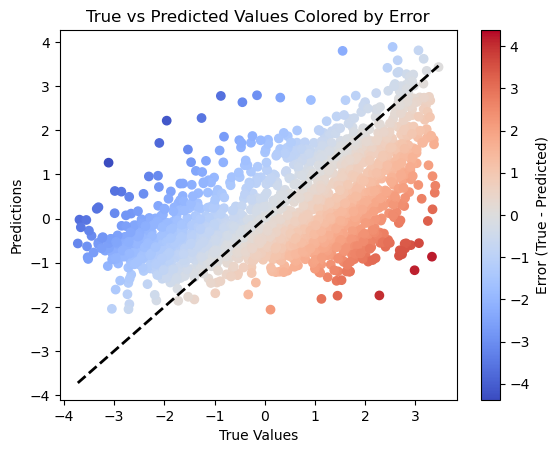

In [34]:
alpha = 0.1
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)
# predict on test set
y_pred = model.predict(X_test)
# evaluate with R^2
r2 = r2_score(y_test, y_pred)
print(f'Final model - Alpha: {alpha}, R^2: {r2:.4f}')

# look at coefficients
coef = pd.Series(model.coef_, index=X.columns)
print(coef)

# plot y vs y_pred
import matplotlib.pyplot as plt


# color by difference from y=y_pred line
plt.scatter(y_test, y_pred, c=(y_test - y_pred), cmap='coolwarm', vmin=-max(abs(y_test - y_pred)), vmax=max(abs(y_test - y_pred)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values Colored by Error')
plt.colorbar(label='Error (True - Predicted)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [35]:
# run a prediction on the full dataset, plot the errors on a map with lat lon using lonboard
gdf_full = gdf[mask].copy()
gdf_full['predicted_asset_index'] = model.predict(X)
gdf_full['error'] = gdf_full['asset_index'] - gdf_full['predicted_asset_index']
gdf_full.head()
gdf_full['abs_error'] = gdf_full['error'].abs()
import numpy as np
gdf_full['normalized_abs_error'] = (gdf_full['abs_error'] - gdf_full['abs_error'].min()) / (gdf_full['abs_error'].max() - gdf_full['abs_error'].min())

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.diverging import RdBu_11

layer = ScatterplotLayer.from_geopandas(
    gdf_full,
    get_fill_color=apply_continuous_cmap(gdf_full['normalized_abs_error'], RdBu_11.mpl_colormap),
    get_radius=10000
)
m = Map(layer, view_state={
        "longitude": 50,
        "latitude": 10,
        "zoom": 2,  
    },
    basemap_style="https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json"
    )
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json', custom_attribution='', l…

## Convert Notebook to HTML

In [2]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

# export to HTML for webpage
import os
os.system('jupyter nbconvert --to html pt4-alphaearth.ipynb --HTMLExporter.theme=dark')

[NbConvertApp] Converting notebook pt4-alphaearth.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 618069 bytes to pt4-alphaearth.html


0